In [58]:
import os

TENSORFLOW = 1
TORCH = 1
if TORCH:
    os.environ['CUDA_VISIBLE_DEVICES']='0'

if TENSORFLOW:
    import os
    import tensorflow as tf


    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            tf.config.set_visible_devices(gpus[0], 'GPU')
            tf.config.set_logical_device_configuration(
                gpus[0],
                [tf.config.LogicalDeviceConfiguration(memory_limit=10000)])
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)


1 Physical GPUs, 1 Logical GPUs


In [59]:
import pandas as pd
from functools import reduce
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
import math
import tensorflow as tf


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

column_names = [
    'ID', 'PARAM', 'TYPE', 'YEAR', 'DD',
    'Jan', 'Jan_SYM', 'Feb', 'Feb_SYM', 'Mar', 'Mar_SYM',
    'Apr', 'Apr_SYM', 'May', 'May_SYM', 'Jun', 'Jun_SYM',
    'Jul', 'Jul_SYM', 'Aug', 'Aug_SYM', 'Sep', 'Sep_SYM',
    'Oct', 'Oct_SYM', 'Nov', 'Nov_SYM', 'Dec', 'Dec_SYM'
]

MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

data = pd.read_csv('data/credit_hydrometric_data_all_stations.csv', skiprows=2, names=column_names)

Num GPUs Available:  1


In [60]:
_02HB018 = data[data['ID'] == '02HB018'].reset_index(drop=True)

_02HB025 = data[data['ID'] == '02HB025'].reset_index(drop=True)

_02HB031 = data[data['ID'] == '02HB031'].reset_index(drop=True)

_02HB001 = data[data['ID'] == '02HB001'].reset_index(drop=True)

_02HB013 = data[data['ID'] == '02HB013'].reset_index(drop=True)

_02HB029 = data[data['ID'] == '02HB029'].reset_index(drop=True)  ### TARGET


In [61]:
import pandas as pd
import calendar

def is_valid_date(year, month, day):
    try:
        m = calendar.monthrange(year, month)
        if day > m[1]:
            return False
        else:
            return True
    except Exception as e:
        print(e)
        return False


def split_by_param_1_2(df: pd.DataFrame):
    data1 = df[df['PARAM'] == 1].reset_index(drop=True)
    data2 = df[df['PARAM'] == 2].reset_index(drop=True)
    return data1, data2

def wateroffice_to_timeseries(df : pd.DataFrame):
    data_dict = {'timestamp': [], 'value': []}

    for i, row in df.iterrows():
        year = row['YEAR']
        day = row['DD']
        for month in MONTHS :
            if is_valid_date(year, MONTHS.index(month) + 1, day):

                timestamp = pd.Timestamp(f'{year}-{month}-{day}')
                val = df.at[i, f'{month}']
                data_dict['timestamp'].append(timestamp)
                data_dict['value'].append(val)

    new_data = pd.DataFrame(data_dict)
    return new_data


def merge_param_1_2(df_left : pd.DataFrame, df_right : pd.DataFrame):
    return pd.merge(df_left, df_right, on='timestamp', how='inner')



In [62]:
_02HB018_1, _02HB018_2 = split_by_param_1_2(_02HB018)
_02HB025_1, _02HB025_2 = split_by_param_1_2(_02HB025)
_02HB031_1, _02HB031_2 = split_by_param_1_2(_02HB031)
_02HB001_1, _02HB001_2 = split_by_param_1_2(_02HB001)
_02HB013_1, _02HB013_2 = split_by_param_1_2(_02HB013)
_02HB029_1, _02HB029_2 = split_by_param_1_2(_02HB029)



In [63]:
_02HB018_1_ts = wateroffice_to_timeseries(_02HB018_1).rename(columns={'value': 'discharge_02HB018'})
_02HB018_2_ts = wateroffice_to_timeseries(_02HB018_2).rename(columns={'value': 'water_level_02HB018'})
_02HB025_1_ts = wateroffice_to_timeseries(_02HB025_1).rename(columns={'value': 'discharge_02HB025'})
_02HB025_2_ts = wateroffice_to_timeseries(_02HB025_2).rename(columns={'value': 'water_level_02HB025'})
_02HB031_1_ts = wateroffice_to_timeseries(_02HB031_1).rename(columns={'value': 'discharge_02HB031'})
_02HB031_2_ts = wateroffice_to_timeseries(_02HB031_2).rename(columns={'value': 'water_level_02HB031'})
_02HB001_1_ts = wateroffice_to_timeseries(_02HB001_1).rename(columns={'value': 'discharge_02HB001'})
_02HB001_2_ts = wateroffice_to_timeseries(_02HB001_2).rename(columns={'value': 'water_level_02HB001'})
_02HB013_1_ts = wateroffice_to_timeseries(_02HB013_1).rename(columns={'value': 'discharge_02HB013'})
_02HB013_2_ts = wateroffice_to_timeseries(_02HB013_2).rename(columns={'value': 'water_level_02HB013'})
_02HB029_1_ts = wateroffice_to_timeseries(_02HB029_1).rename(columns={'value': 'discharge_02HB029'})
_02HB029_2_ts = wateroffice_to_timeseries(_02HB029_2).rename(columns={'value': 'water_level_02HB029'})

In [87]:
def merge_param_1_2(df_left : pd.DataFrame, df_right : pd.DataFrame):
    return pd.merge(df_left, df_right, on='timestamp', how='inner')


def fill_na(df: pd.DataFrame):
    df.ffill(inplace=True)
    df.bfill(inplace=True)
    return df


In [81]:
merged_02HB018 = merge_param_1_2(_02HB018_1_ts, _02HB018_2_ts)
merged_02HB025 = merge_param_1_2(_02HB025_1_ts, _02HB025_2_ts)
merged_02HB031 = merge_param_1_2(_02HB031_1_ts, _02HB031_2_ts)
merged_02HB001 = merge_param_1_2(_02HB001_1_ts, _02HB001_2_ts)
merged_02HB013 = merge_param_1_2(_02HB013_1_ts, _02HB013_2_ts)
merged_02HB029 = merge_param_1_2(_02HB029_1_ts, _02HB029_2_ts)

In [88]:
# merge into single dataframe with dischrage and water_level for all stations and add suffix to columns, dont have redundant columns
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['timestamp'],
                                            how='outer'), [merged_02HB018, merged_02HB025, merged_02HB031, merged_02HB001, merged_02HB013, merged_02HB029])

In [89]:
df_merged.set_index('timestamp', inplace=True)

df_merged = fill_na(df_merged)

In [124]:
def add_lag_times(df: pd.DataFrame):
    lag_times = {
        '02HB018': 7,
        '02HB025': 6,
        '02HB031': 9,
        '02HB001': 8,
        '02HB013': 12
    }

    df = df_hourly.copy()

    for column in df_hourly.columns:
        for station, lag in lag_times.items():
            if station in column: 
                df[f'{column}_lagged'] = df[column].shift(lag)

    return df

def interpolate_hourly(df: pd.DataFrame):
    df_hourly = df.resample('6H').interpolate('linear')
    df_hourly = fill_na(df_hourly)
    return df_hourly

df_hourly = interpolate_hourly(df_merged)

df_hourly_lagged = add_lag_times(df_hourly)

df_hourly_lagged = fill_na(df_hourly_lagged)


/tmp/ipykernel_14050/769696088.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('6H').interpolate('linear')


In [125]:
df_hourly

,discharge_02HB018,water_level_02HB018,discharge_02HB025,water_level_02HB025,discharge_02HB031,water_level_02HB031,discharge_02HB001,water_level_02HB001,discharge_02HB013,water_level_02HB013,discharge_02HB029,water_level_02HB029
timestamp,,,,,,,,,,,,
2002-01-01 00:00:00,2.5000,3.94400,3.2700,2.829,0.288,2.014,1.2000,1.4750,0.38000,11.20500,12.1000,4.563
2002-01-01 06:00:00,2.4925,3.95375,3.2625,2.836,0.288,2.014,1.1975,1.4745,0.37875,11.20475,12.1000,4.563
2002-01-01 12:00:00,2.4850,3.96350,3.2550,2.843,0.288,2.014,1.1950,1.4740,0.37750,11.20450,12.1000,4.563
2002-01-01 18:00:00,2.4775,3.97325,3.2475,2.850,0.288,2.014,1.1925,1.4735,0.37625,11.20425,12.1000,4.563
2002-01-02 00:00:00,2.4700,3.98300,3.2400,2.857,0.288,2.014,1.1900,1.4730,0.37500,11.20400,12.1000,4.563
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-30 00:00:00,4.3700,3.93200,12.3000,2.843,0.303,1.969,3.1300,1.5210,0.55100,11.21900,11.2000,4.660
2023-12-30 06:00:00,4.2125,3.92075,12.3000,2.843,0.303,1.969,3.1300,1.5210,0.52425,11.21500,10.5275,4.643
2023-12-30 12:00:00,4.0550,3.90950,12.3000,2.843,0.303,1.969,3.1300,1.5210,0.49750,11.21100,9.8550,4.626


In [126]:
df_hourly_lagged

,discharge_02HB018,water_level_02HB018,discharge_02HB025,water_level_02HB025,discharge_02HB031,water_level_02HB031,discharge_02HB001,water_level_02HB001,discharge_02HB013,water_level_02HB013,...,discharge_02HB018_lagged,water_level_02HB018_lagged,discharge_02HB025_lagged,water_level_02HB025_lagged,discharge_02HB031_lagged,water_level_02HB031_lagged,discharge_02HB001_lagged,water_level_02HB001_lagged,discharge_02HB013_lagged,water_level_02HB013_lagged
timestamp,,,,,,,,,,,,,,,,,,,,,
2002-01-01 00:00:00,2.5000,3.94400,3.2700,2.829,0.288,2.014,1.2000,1.4750,0.38000,11.20500,...,2.5000,3.94400,3.27,2.829,0.288,2.014,1.20,1.475,0.380,11.205
2002-01-01 06:00:00,2.4925,3.95375,3.2625,2.836,0.288,2.014,1.1975,1.4745,0.37875,11.20475,...,2.5000,3.94400,3.27,2.829,0.288,2.014,1.20,1.475,0.380,11.205
2002-01-01 12:00:00,2.4850,3.96350,3.2550,2.843,0.288,2.014,1.1950,1.4740,0.37750,11.20450,...,2.5000,3.94400,3.27,2.829,0.288,2.014,1.20,1.475,0.380,11.205
2002-01-01 18:00:00,2.4775,3.97325,3.2475,2.850,0.288,2.014,1.1925,1.4735,0.37625,11.20425,...,2.5000,3.94400,3.27,2.829,0.288,2.014,1.20,1.475,0.380,11.205
2002-01-02 00:00:00,2.4700,3.98300,3.2400,2.857,0.288,2.014,1.1900,1.4730,0.37500,11.20400,...,2.5000,3.94400,3.27,2.829,0.288,2.014,1.20,1.475,0.380,11.205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-30 00:00:00,4.3700,3.93200,12.3000,2.843,0.303,1.969,3.1300,1.5210,0.55100,11.21900,...,5.4225,4.00200,12.30,2.843,0.303,1.969,3.13,1.521,0.652,11.228
2023-12-30 06:00:00,4.2125,3.92075,12.3000,2.843,0.303,1.969,3.1300,1.5210,0.52425,11.21500,...,5.1650,3.98500,12.30,2.843,0.303,1.969,3.13,1.521,0.662,11.230
2023-12-30 12:00:00,4.0550,3.90950,12.3000,2.843,0.303,1.969,3.1300,1.5210,0.49750,11.21100,...,4.9075,3.96800,12.30,2.843,0.303,1.969,3.13,1.521,0.672,11.232


In [103]:
assert(len(df_merged.index.to_series().diff().dt.days.unique()) == 2)
assert(len(df_hourly.index.to_series().diff().dt.days.unique()) == 2)

In [108]:
df_hourly.head(2)

,discharge_02HB018,water_level_02HB018,discharge_02HB025,water_level_02HB025,discharge_02HB031,water_level_02HB031,discharge_02HB001,water_level_02HB001,discharge_02HB013,water_level_02HB013,...,discharge_02HB018_lagged,water_level_02HB018_lagged,discharge_02HB025_lagged,water_level_02HB025_lagged,discharge_02HB031_lagged,water_level_02HB031_lagged,discharge_02HB001_lagged,water_level_02HB001_lagged,discharge_02HB013_lagged,water_level_02HB013_lagged
timestamp,,,,,,,,,,,,,,,,,,,,,
2002-01-01 00:00:00,2.50000,3.944000,3.27000,2.829000,0.288,2.014,1.200000,1.475000,0.380000,11.205000,...,2.5,3.944,3.27,2.829,0.288,2.014,1.2,1.475,0.38,11.205
2002-01-01 01:00:00,2.49875,3.945625,3.26875,2.830167,0.288,2.014,1.199583,1.474917,0.379792,11.204958,...,2.5,3.944,3.27,2.829,0.288,2.014,1.2,1.475,0.38,11.205


In [13]:
df_merged.head(2)

,discharge_02HB018,water_level_02HB018,discharge_02HB025,water_level_02HB025,discharge_02HB031,water_level_02HB031,discharge_02HB001,water_level_02HB001,discharge_02HB013,water_level_02HB013,discharge_02HB029,water_level_02HB029
timestamp,,,,,,,,,,,,
2002-01-01,2.50,3.944,3.27,2.829,0.288,2.014,1.20,1.475,0.380,11.205,12.1,4.563
2002-01-02,2.47,3.983,3.24,2.857,0.288,2.014,1.19,1.473,0.375,11.204,12.1,4.563


In [110]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, BatchNormalization, Bidirectional, LayerNormalization, ConvLSTM1D, Flatten, Dropout

def make_lstm(input_shape):

    #_LSTM = Sequential()
    #_LSTM.add(LSTM(100, return_sequences=True, input_shape=input_shape, dropout=0.2, recurrent_dropout=0.2))
    #_LSTM.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    #_LSTM.add(Dense(1))
    _LSTM = Sequential()
    _LSTM.add(Bidirectional(LSTM(100, return_sequences=True, input_shape=input_shape, dropout=0.2, recurrent_dropout=0.2)))
    _LSTM.add(BatchNormalization())
    _LSTM.add(Bidirectional(LSTM(50, dropout=0.2, recurrent_dropout=0.2)))
    _LSTM.add(BatchNormalization())
    _LSTM.add(Dense(1))

    return _LSTM

def make_gru(input_shape):

    _GRU = Sequential()
    _GRU.add(GRU(50, return_sequences=True, input_shape=input_shape, dropout=0.2))
    _GRU.add(LayerNormalization())
    _GRU.add(GRU(25, dropout=0.2))
    _GRU.add(Dense(1))

    return _GRU

def make_conv_lstm(input_shape):
    _CONVLSTM = Sequential()
    _CONVLSTM.add(ConvLSTM1D(filters=32, kernel_size=3, return_sequences=True, input_shape=input_shape))
    _CONVLSTM.add(BatchNormalization())
    #_CNNLSTM.add(ConvLSTM1D(filters=32, kernel_size=3, return_sequences=False))
    #_CNNLSTM.add(BatchNormalization())
    _CONVLSTM.add(Flatten())
    _CONVLSTM.add(Dense(50, activation='relu'))
    _CONVLSTM.add(Dropout(0.25))
    _CONVLSTM.add(Dense(1))

    return _CONVLSTM

In [128]:



from keras.optimizers import Adam


scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_hourly_lagged)

def create_dataset(data :np.array, look_back=1):
    """
    set y as the next value in the sequence at the last index (water_level_02HB029)
    """
    X, Y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back), :]
        X.append(a)
        Y.append(data[i + look_back, -1])
    return np.array(X), np.array(Y)

look_back = 1
X, Y = create_dataset(df_scaled, look_back)

test_size = int(len(X) * 0.20)
train_size = len(X) - test_size
val_size = int(train_size * 0.20)

X_train, X_val = X[:train_size-val_size], X[train_size-val_size:train_size]
Y_train, Y_val = Y[:train_size-val_size], Y[train_size-val_size:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

#model = make_gru((look_back, df_scaled.shape[1]))
#model = make_lstm((look_back, df_scaled.shape[1]))
model = make_conv_lstm((look_back, df_scaled.shape[1],1))

adam = Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer=adam)

history = model.fit(X_train, Y_train, epochs=10, batch_size=256, verbose=2,
                     validation_data=(X_val, Y_val))

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(
    np.hstack((np.zeros((predictions.shape[0], df_scaled.shape[1]-1)), predictions)))

Y_test = scaler.inverse_transform(
    np.hstack((np.zeros((Y_test.shape[0], df_scaled.shape[1]-1)), Y_test.reshape(-1, 1))))[:, -1]

predictions = predictions[:, -1]

rmse = math.sqrt(mean_squared_error(Y_test, predictions))
mae = np.mean(np.abs(predictions - Y_test))
print(f'Test Score: {mae:.4f} MAE')
print(f'Test Score: {rmse:.4f} RMSE')

Epoch 1/10
81/81 - 3s - loss: 0.0014 - val_loss: 0.0082 - 3s/epoch - 41ms/step
Epoch 2/10
81/81 - 1s - loss: 3.9036e-04 - val_loss: 0.0064 - 643ms/epoch - 8ms/step
Epoch 3/10
81/81 - 1s - loss: 3.0591e-04 - val_loss: 0.0055 - 739ms/epoch - 9ms/step
Epoch 4/10
81/81 - 1s - loss: 2.8992e-04 - val_loss: 0.0048 - 686ms/epoch - 8ms/step
Epoch 5/10
81/81 - 1s - loss: 2.5845e-04 - val_loss: 0.0041 - 626ms/epoch - 8ms/step
Epoch 6/10
81/81 - 1s - loss: 2.9481e-04 - val_loss: 0.0031 - 681ms/epoch - 8ms/step
Epoch 7/10
81/81 - 1s - loss: 2.7704e-04 - val_loss: 0.0022 - 689ms/epoch - 9ms/step
Epoch 8/10
81/81 - 1s - loss: 2.4221e-04 - val_loss: 0.0012 - 697ms/epoch - 9ms/step
Epoch 9/10
81/81 - 1s - loss: 2.3144e-04 - val_loss: 9.0149e-04 - 710ms/epoch - 9ms/step
Epoch 10/10
81/81 - 1s - loss: 2.4092e-04 - val_loss: 6.1017e-04 - 693ms/epoch - 9ms/step
201/201 [==============================] - 0s 2ms/step
Test Score: 0.02 MAE
Test Score: 0.02 RMSE


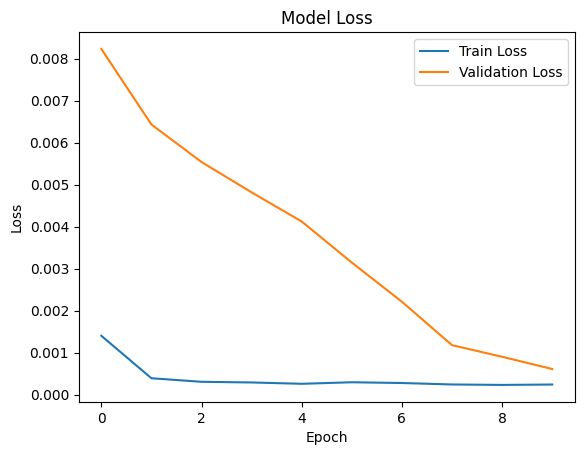

In [129]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()